# MLE in Python

Implementing MLE in your data science modeling pipeline can be done with a variety of approaches. Below is one approach to get started.

In [4]:
# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats

!pip install pymc3 numdifftools statsmodels
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline



     |████████████████████████████████| 10.5MB 1.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


generate data that follows a normally distributed errors around a ground truth function, & visualize using Seaborn’s regplot:

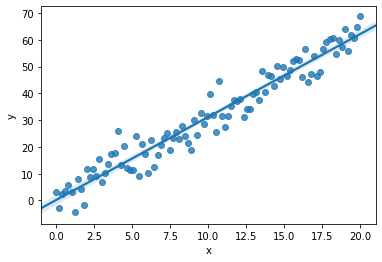

In [7]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

# plot
sns.regplot(df.x, df.y);

## Modeling OLS with Statsmodels

Since we created regression-like, continuous data, now use sm.OLS to calculate the best coefficients and Log-likelihood (LL) as a benchmark, and record the fitted model’s coefficients.

In [9]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1561.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           5.23e-62
Time:                        20:37:25   Log-Likelihood:                -293.00
No. Observations:                 100   AIC:                             590.0
Df Residuals:                      98   BIC:                             595.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.1742      0.909      0.192      0.848      -1.629       1.977
x              3.1012      0.078     39.507      0.000       2.945       3.257
==============================================================================
Omnibus:                        0.134   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.262
Skew:                           0.076   Prob(JB):                        0.877
Kurtosis:                       2.801   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice constant is close to zero, and beta for feature x is close to 3, per the ground truth generator we used

## Maximizing LL to solve for Optimal Coefficients
Using a combination of packages and custom functions to see if we can calculate the same OLS results above using MLE methods.

Because scipy.optimize has only a minimize method, we'll minimize the negative of the log-likelihood. This is even what they recommend! 

We can build a simple function that does everything in one pass for regression outputs:

In [10]:
# define likelihood function
def MLERegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    # return negative LL
    return(negLL)

Now that we have a cost function, let’s initialize and minimize it:

In [12]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
 options={'disp': True})


Optimization terminated successfully.
         Current function value: 293.001761
         Iterations: 98
         Function evaluations: 176


Let’s check the results:

In [13]:
results # this gives us verbosity around our minimization
# notice our final key and associated values…

 final_simplex: (array([[0.17414544, 3.1012276 , 4.53162981],
       [0.17422879, 3.10122458, 4.53164667],
       [0.17424262, 3.10121812, 4.53162718],
       [0.17423346, 3.10122002, 4.5316541 ]]), array([293.0017614 , 293.0017614 , 293.0017614 , 293.00176141]))
           fun: 293.00176139970586
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 98
        status: 0
       success: True
             x: array([0.17414544, 3.1012276 , 4.53162981])

And we can clean up further:

In [14]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)


,coef
constant,0.1741
x,3.1012


do our numbers match the OLS model?

# MLE vs. MAP

MLE and MAP are very similar, but MLE is a special case of MAP, where a uniform prior is used.

Some Definitions:
MLE produces a point estimate that maximizes likelihood function of the unknow parameters given observations (i.e., data)

MAP is a generalized case of MLE. It also produces a point estimate, which is the mode of the posterior distribution of the parameters

Expectation Maximisation (EM) is an iterative method that tries to find MLE/MAP estimates of parameters when marginal probability is intractable (e.g., when there’re missing data or latent variables)

Variational Inference (VI) is a Bayesian method that provides a posterior distribution over the parameters instead of point estimates.

Example: 
Suppose that we have a coin but we do not know if it is fair not. In other words, we have no idea whether the probability of getting head (H) is the same as tail (T). In this case, how can we estimate such probability?

A natural way to do this is to flip this coin for several times to see how many H’s and T’s do we have. Let’s go with a random experiment. Before we start the experiment, let’s define some notations:

X: a random variable that represents the coin toss outcome (1 for H and 0 for T)
θ: the probability of getting H 

Now, let’s assume that we don’t know θ (here, we will use θ = 0.7) and we are going to use random number generator to get some samples and see what the data is like. Let’s start by flip the coin 10 times.

In [16]:
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

n = 10
theta = 0.7
X_arr = np.random.choice([0, 1], p=[1-theta, theta], size=10)
X_arr


array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1])

We get 7 H’s and 3 T’s. Intuitively, we will do the following calculation even if we are not statisticians:

θ = 7 / 10 = 0.7

This seems to be a reasonable guess. 

MLE

In fact, θ is exactly what we get by using MLE! In the context of a coin toss, we can use Bernoulli distribution to model x :

p(x=1)=θ=1−p(x=0)=1−θ

MLE states that our best guess (techinically, estimation) for θ based on observations we have. Specifically, such θ should be maximizing the likelihood function L(θ;x). That’s also why this method is named maximum likelihood estimation.

Concretely, in our example, we can write down the probability mass function of x to be:

p(x | θ) = θ^x (1−θ)^(1−x)

What’s likelihood function then? It is actually just the equation above. However, instead of thinking p(x) as a function of x, we think of it as a function of θ, given the data:

L(θ;x) = θ^x (1−θ)^(1−x)

we can apply the LL (log likelihood) equations as explained in the tutorial slides

## MAP

MLE works pretty well in the previous example. However, this is not as intuitive as how human infers something. Typically, our belief on things may vary over time. Specifically, we start with some prior knowledge to draw an initial guess. With more evidence, we can then modify our belief and obtain posterior probability of some events of interest. This is exactly Bayesian statistics.

Note that MAP is not completely Bayesian because it only gives a point estimate

Back to the coin toss example. If our data looks like this:

In [26]:
X_arr = np.ones(n)
X_arr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Visualizing MAP

As a last example, let’s see the iterative process of how posterior is updated given new data. Let’s assume the true 
θ to be 0.7. Let’s use a non-flat Beta prior with α = β = 2.

In [27]:
alpha = beta = 2
theta = 0.7
n = 50
X_arr = np.random.choice([0, 1], p=[1-theta, theta], size=n)
sum(X_arr) /  X_arr.size

0.7

Recall that our posterior is updated as Beta(α+xi,β+1−xi) with every input data xi.

In [28]:
beta_arr = np.asarray([[alpha+sum(X_arr[:i+1]), beta+(i+1-sum(X_arr[:i+1]))] for i in range(X_arr.size)])
beta_arr = np.insert(beta_arr, 0, [alpha, beta], 0)

Let’s see how the posterior changes when we have more data points

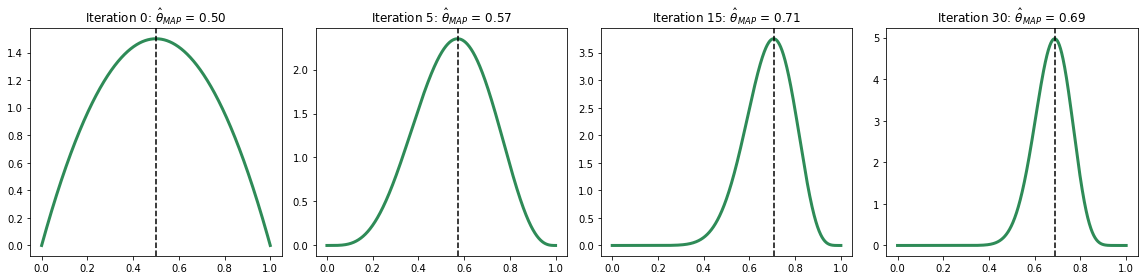

In [29]:
beta_X = np.linspace(0, 1, 1000)
my_color = '#2E8B57'
fig, ax_arr = plt.subplots(ncols=4, figsize=(16,4), sharex=True)
for i, iter_ in enumerate([0, 5, 15, 30]):
    ax = ax_arr[i]
    a, b = beta_arr[iter_]
    beta_Y = sp.stats.beta.pdf(x=beta_X, a=a, b=b)
    ax.plot(beta_X, beta_Y, color=my_color, linewidth=3)
    if a > 1 and b > 1:
        mode = (a-1)/(a+b-2)
    else:
        mode = a/(a+b)
    ax.axvline(x=mode, linestyle='--', color='k')
    ax.set_title('Iteration %d: $\hat{\\theta}_{MAP}$ = %.2f'%(iter_, mode))
fig.tight_layout()

# Another MLE Example:

Maximum Likelihood Estimation of Custom Models in Python with StatsModels
based on http://austinrochford.com/posts/2015-03-03-mle-python-statsmodels.html
Distribution
Uses custom zero-inflated Poisson model.

P(X = x) = (1 - \pi) e ^{-\lambda} \frac{\lambda^{x}}{x!},

for x > 0

In [30]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

# list available fonts: [f.name for f in matplotlib.font_manager.fontManager.ttflist]
# fix warning: /opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
matplotlib.rc('font', family='DejaVu Sans')

pi_default = 0.3
lambda_default = 2.0

In [31]:
def zip_pmf(x, pi=pi_default, lambda_=lambda_default):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

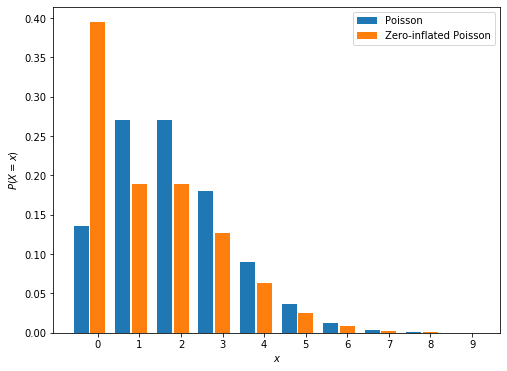

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = np.arange(0, 10);

palette = sns.color_palette()

ax.bar(2.5 * xs, stats.poisson.pmf(xs, lambda_default), width=0.9, color=palette[0], label='Poisson');
ax.bar(2.5 * xs + 1, zip_pmf(xs), width=0.9, color=palette[1], label='Zero-inflated Poisson');

ax.set_xticks(2.5 * xs + 1);
ax.set_xticklabels(xs);
ax.set_xlabel('$x$');

ax.set_ylabel('$P(X = x)$');

ax.legend();
plt.show()


Maximum likelihood estimation

In [33]:
N = 1000 # observations
inflated_zero = stats.bernoulli.rvs(pi_default, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_default, size=N)

/Users/manal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


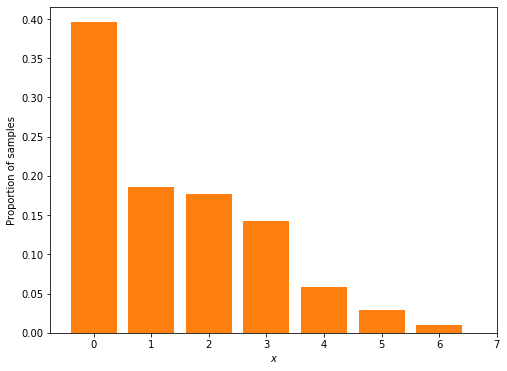

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, width=0.8, bins=np.arange(x.max() + 1), normed=True, color=palette[1]);

ax.set_xticks(np.arange(x.max() + 1) + 0.4);
ax.set_xticklabels(np.arange(x.max() + 1));
ax.set_xlabel('$x$');

ax.set_ylabel('Proportion of samples');

plt.show()

Estimate parameters \pi and \lambda

In [35]:
class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super().__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super().fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun, **kwds)

In [36]:
model = ZeroInflatedPoisson(x)
results = model.fit()

pi_mle, lambda_mle = results.params

pi_mle, lambda_mle

Optimization terminated successfully.
         Current function value: 1.586385
         Iterations: 39
         Function evaluations: 74


(0.30456084662134125, 2.0289473949517696)

# Maximum Likelihood Estimation vs Maximum a Posteriori Notebook

Create Simulation Enviroment
In this example $Y=AX+N$ simulation enviroment will be created. In this equation:
Y is the observation
A is system geometry parameters
X is varible (the thing which is observed )
N is randomly distrubuted zero mean gaussian noise
Size of this vector and matrices are:  Y_{mx1}=A_{mxn}X_{nx1} + N_{mx1} 



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

#plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

Helper Functions

In [38]:
#convert to vector
def toVector(a):
    return a.reshape(-1,1) 
    
def toImage(a):
    return a.reshape(K,L)

def convLog(arr):
    sample10 = np.mean( arr[0:10] )
    sample100 = np.mean( arr[0:100] )
    sample1_000 = np.mean( arr[0:1000] )
    sample10_000 = np.mean( arr[0:10000] )
    return [sample10, sample100, sample1_000, sample10_000]

Implementation of ML and MAP at 100x100

In [39]:
K = 100
L = 100
m = int(1.2*K*L)
n = K*L

# Create X read image
X_image = misc.imread('test/test1.jpg', mode="L") # grayscale mode
X_image = misc.imresize(X_image, (K,L))/ 255 # normalize image
X = toVector(X_image)
A = np.random.rand(m,n)


def calculateMaxlikelihood(A, X, NoisePower):
    # every time new noise will be generated randomly
    N =  (np.random.rand(m,1)-0.5) * NoisePower
    Y = A@X + N
    # return Xml
    return  np.linalg.inv(A.transpose() @ A ) @ A.transpose() @ Y

def calculateMaximumAPosteriori(A, X, NoisePower, B):
    # every time new noise will be generated randomly
    N =  (np.random.rand(m,1)-0.5) * NoisePower
    Y = A@X + N
    I1 = np.ones((n,n))
    I2 = np.ones((n,1))
    # return Xmap
    return  np.linalg.inv(A.transpose() @ A + B * I1 ) @ ( A.transpose() @ Y + B*X.mean()*I2)

print("Started.")
Xml =  calculateMaxlikelihood(A,X,1)
print("ML done.")
Xmap01 =  calculateMaximumAPosteriori(A,X,1,0.1)
print("MAP01 done")
Xmap03 =  calculateMaximumAPosteriori(A,X,1,0.3)
print("MAP03 done")
Xmap05 =  calculateMaximumAPosteriori(A,X,1,0.5)
print("MAP05 done")
Xmap10 =  calculateMaximumAPosteriori(A,X,1,1.0)
print("MAP10 done")

AttributeError: module 'scipy.misc' has no attribute 'imread'